# Getting started with DeBaCl

## Load Data

Our first step is to create some data using the scikit-learn `make_blobs` and `make_circles` utility. To make this a hard (but not impossible) clustering problem, we set the random state of the blob so that it's always outside the two concentric circles.

In [63]:
import numpy as np
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
import csv
%matplotlib inline
X_unbalanced = np.genfromtxt('unbalanced_banana.csv', delimiter=',')
X_balanced = np.genfromtxt('banana.csv', delimiter=',')
X_target = np.genfromtxt('taerget_generated_data.csv', delimiter=',')
print "Dataset shape:", X_unbalanced.shape, X_balanced.shape, X_target.shape


Dataset shape: (1800L, 2L) (5000L, 2L) (2000L, 2L)


Unbalanced Moon

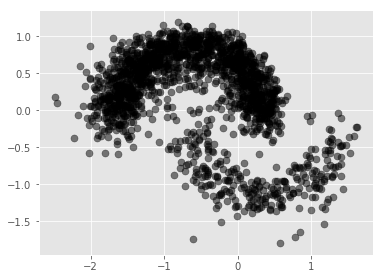

In [6]:
X = X_unbalanced
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(X[:, 0], X[:, 1], c='black', s=50, alpha=0.5)

Balanced Moon

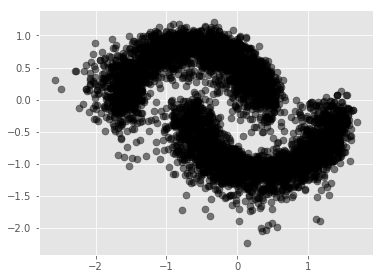

In [7]:
X = X_balanced
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(X[:, 0], X[:, 1], c='black', s=50, alpha=0.5)

Target

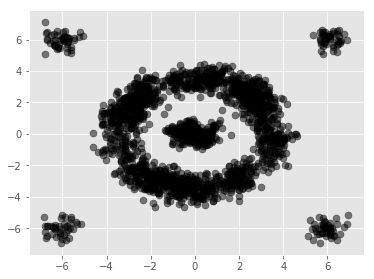

In [8]:
X = X_target
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(X[:, 0], X[:, 1], c='black', s=50, alpha=0.5)

##  DBSCAN

In [20]:
X = X_unbalanced
from sklearn.cluster import DBSCAN
# Compute DBSCAN
db = DBSCAN(eps=0.2, min_samples=15).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
y = db.labels_

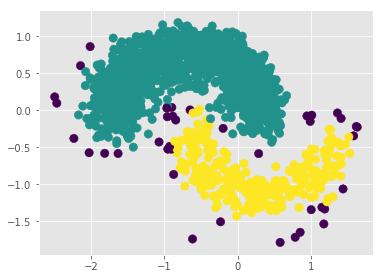

In [21]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(X[:, 0], X[:, 1],
               c=y, s=70)

In [22]:
X = X_balanced
from sklearn.cluster import DBSCAN
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=15).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
y = db.labels_

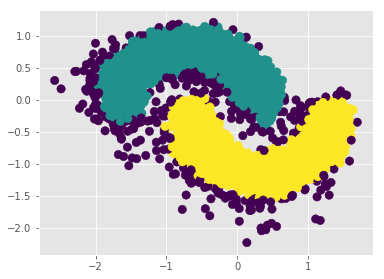

In [23]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(X[:, 0], X[:, 1],
               c=y, s=70)

In [24]:
X = X_target
from sklearn.cluster import DBSCAN
# Compute DBSCAN
db = DBSCAN(eps=0.5, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
y = db.labels_

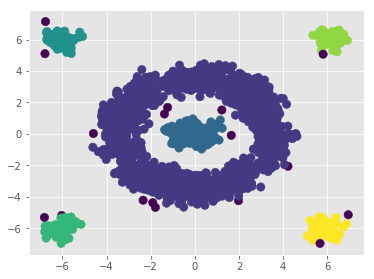

In [25]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(X[:, 0], X[:, 1],
               c=y, s=70)

## GMM

Unbalanced

In [26]:
X = X_unbalanced
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2)
gmm.fit(X)
y= gmm.predict(X)

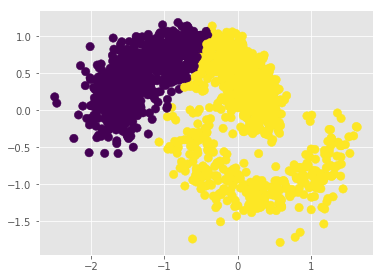

In [27]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(X[:, 0], X[:, 1],
               c=y, s=70)

Balanced

In [28]:
X = X_balanced
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2)
gmm.fit(X)
y= gmm.predict(X)

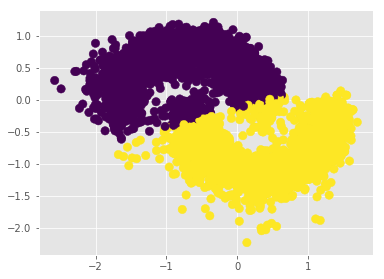

In [29]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(X[:, 0], X[:, 1],
               c=y, s=70)

Target

In [32]:
X = X_target
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=6)
gmm.fit(X)
y= gmm.predict(X)

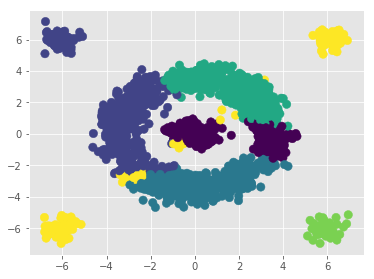

In [33]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(X[:, 0], X[:, 1],
               c=y, s=70)

##  DeBaCl

Unbalanced

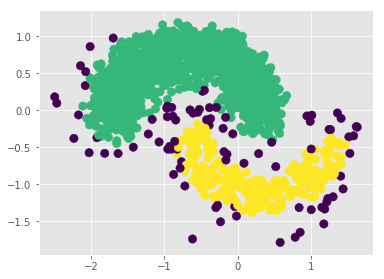

In [64]:
import debacl as dcl
X = X_unbalanced
tree = dcl.construct_tree(X, k=15)
cluster_labels = tree.get_clusters(method='first-k',fill_background=True, k=2 ,prune_threshold=0)
X_foreground = X[(cluster_labels[:,1] != -1),:]
y_foreground = cluster_labels[(cluster_labels[:,1] != -1),:]
X_background = X[(cluster_labels[:,1] == -1),:]
upper_level_idx = cluster_labels[:, 0]
upper_level_set = X[upper_level_idx, :]
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(upper_level_set[:, 0], upper_level_set[:, 1],
               c=cluster_labels[:, 1], s=70)
#print tree

In [67]:
print len(cluster_labels)

5000


Balanced

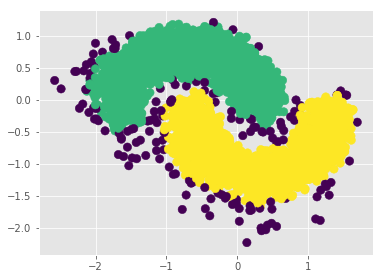

In [66]:
import debacl as dcl
X = X_balanced
tree = dcl.construct_tree(X, k=15)
cluster_labels = tree.get_clusters(method='first-k',fill_background=True, k=2 ,prune_threshold=0)
X_foreground = X[(cluster_labels[:,1] != -1),:]
y_foreground = cluster_labels[(cluster_labels[:,1] != -1),:]
X_background = X[(cluster_labels[:,1] == -1),:]
upper_level_idx = cluster_labels[:, 0]
upper_level_set = X[upper_level_idx, :]
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(upper_level_set[:, 0], upper_level_set[:, 1],
               c=cluster_labels[:, 1], s=70)

Target

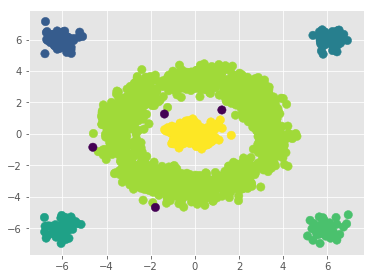

In [5]:
import debacl as dcl
X = X_target
tree = dcl.construct_tree(X, k=15)
cluster_labels = tree.get_clusters(method='first-k',fill_background=True, k=6 ,prune_threshold=0)
X_foreground = X[(cluster_labels[:,1] != -1),:]
y_foreground = cluster_labels[(cluster_labels[:,1] != -1),:]
X_background = X[(cluster_labels[:,1] == -1),:]
upper_level_idx = cluster_labels[:, 0]
upper_level_set = X[upper_level_idx, :]
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(upper_level_set[:, 0], upper_level_set[:, 1],
               c=cluster_labels[:, 1], s=70)

In [6]:
#cluster_labels = pruned_tree.get_clusters()
#cluster_labels = tree.get_clusters(method='first-k',fill_background=True, k=2 )

#use knn to classify background pts
#from sklearn.neighbors import KNeighborsClassifier
#knn = KNeighborsClassifier(n_neighbors=20)
#knn.fit(X_foreground, y_foreground)
#y_background = knn.predict(X_background)
#cluster_labels[(cluster_labels[:,1] == -1),:] = y_background

## Test GMM

In [30]:
import numpy as np
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
import csv
ari = []
for i in range(1, 101):
    X= np.genfromtxt('unbalanced_moon/X_'+ str(i) + '.csv', delimiter=',')
    y_true= np.genfromtxt('unbalanced_moon/y_' + str(i) + '.csv', delimiter=',')
    from sklearn.mixture import GaussianMixture
    gmm = GaussianMixture(n_components=2)
    gmm.fit(X)
    y_pred= gmm.predict(X)
    from sklearn import metrics
    ari_i = metrics.adjusted_rand_score(y_true, y_pred)
    ari.append(ari_i)
ari = np.array(ari)

In [31]:
print('ARI of GMM on unbalanced moon:')
print('Mean:')
print(np.mean(ari))
print('Median:')
print(np.median(ari))
print('Standard Deviation:')
print(np.var(ari))

ARI of GMM on unbalanced moon:
Mean:
0.07892788072738931
Median:
0.07843016275480086
Standard Deviation:
0.0003388750187850211


In [32]:
import numpy as np
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
import csv
ari = []
for i in range(1, 101):
    X= np.genfromtxt('balanced_moon/X_'+ str(i) + '.csv', delimiter=',')
    y_true= np.genfromtxt('balanced_moon/y_' + str(i) + '.csv', delimiter=',')
    from sklearn.mixture import GaussianMixture
    gmm = GaussianMixture(n_components=2)
    gmm.fit(X)
    y_pred= gmm.predict(X)
    from sklearn import metrics
    ari_i = metrics.adjusted_rand_score(y_true, y_pred)
    ari.append(ari_i)
ari = np.array(ari)

In [33]:
print('ARI of GMM on balanced moon:')
print('Mean:')
print(np.mean(ari))
print('Median:')
print(np.median(ari))
print('Standard Deviation:')
print(np.var(ari))

ARI of GMM on balanced moon:
Mean:
0.7824876347998517
Median:
0.7831816732520849
Standard Deviation:
0.00019807218480520885


In [35]:
import numpy as np
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
import csv
ari = []
for i in range(1, 101):
    X= np.genfromtxt('target/X_'+ str(i) + '.csv', delimiter=',')
    y_true= np.genfromtxt('target/y_' + str(i) + '.csv', delimiter=',')
    from sklearn.mixture import GaussianMixture
    gmm = GaussianMixture(n_components=6)
    gmm.fit(X)
    y_pred= gmm.predict(X)
    from sklearn import metrics
    ari_i = metrics.adjusted_rand_score(y_true, y_pred)
    ari.append(ari_i)
ari = np.array(ari)

In [36]:
print('ARI of GMM on Target:')
print('Mean:')
print(np.mean(ari))
print('Median:')
print(np.median(ari))
print('Standard Deviation:')
print(np.var(ari))

ARI of GMM on Target:
Mean:
0.1257287077121606
Median:
0.12405482739307959
Standard Deviation:
0.002239564728917684


## Test DBSCAN

In [42]:
import numpy as np
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
import csv
ari = []
for i in range(1, 101):
    X= np.genfromtxt('unbalanced_moon/X_'+ str(i) + '.csv', delimiter=',')
    y_true= np.genfromtxt('unbalanced_moon/y_' + str(i) + '.csv', delimiter=',')
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=0.2, min_samples=20).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    y_pred = db.labels_
    from sklearn import metrics
    ari_i = metrics.adjusted_rand_score(y_true, y_pred)
    ari.append(ari_i)
ari = np.array(ari)

In [43]:
print('ARI of DBSCAN on Unbalanced Moon:')
print('Mean:')
print(np.mean(ari))
print('Median:')
print(np.median(ari))
print('Standard Deviation:')
print(np.var(ari))

ARI of DBSCAN on Unbalanced Moon:
Mean:
0.8866737006849127
Median:
0.9580531580779981
Standard Deviation:
0.05943001532601959


In [58]:
import numpy as np
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
import csv
ari = []
for i in range(1, 101):
    X= np.genfromtxt('balanced_moon/X_'+ str(i) + '.csv', delimiter=',')
    y_true= np.genfromtxt('balanced_moon/y_' + str(i) + '.csv', delimiter=',')
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=0.1, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    y_pred = db.labels_
    from sklearn import metrics
    ari_i = metrics.adjusted_rand_score(y_true, y_pred)
    ari.append(ari_i)
ari = np.array(ari)

In [59]:
print('ARI of DBSCAN on Balanced Moon:')
print('Mean:')
print(np.mean(ari))
print('Median:')
print(np.median(ari))
print('Standard Deviation:')
print(np.var(ari))

ARI of DBSCAN on Balanced Moon:
Mean:
0.9132898179305116
Median:
0.9133845243617675
Standard Deviation:
4.664356012108026e-05


In [52]:
import numpy as np
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
import csv
ari = []
for i in range(1, 101):
    X= np.genfromtxt('target/X_'+ str(i) + '.csv', delimiter=',')
    y_true= np.genfromtxt('target/y_' + str(i) + '.csv', delimiter=',')
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=0.5, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    y_pred = db.labels_
    from sklearn import metrics
    ari_i = metrics.adjusted_rand_score(y_true, y_pred)
    ari.append(ari_i)
ari = np.array(ari)

In [53]:
print('ARI of DBSCAN on Target:')
print('Mean:')
print(np.mean(ari))
print('Median:')
print(np.median(ari))
print('Standard Deviation:')
print(np.var(ari))

ARI of DBSCAN on Target:
Mean:
0.958392110009435
Median:
0.9814235508639714
Standard Deviation:
0.010979164386639735


## Test DeBaCl

In [90]:
import numpy as np
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
import csv
ari = []
for i in range(1, 5):
    X= np.genfromtxt('unbalanced_moon/X_'+ str(i) + '.csv', delimiter=',')
    y_true= np.genfromtxt('unbalanced_moon/y_' + str(i) + '.csv', delimiter=',')
    import debacl as dcl
    tree = dcl.construct_tree(X, k=15)
    y_pred = tree.get_clusters(method='first-k',fill_background=True, k=2 ,prune_threshold=0)
    y_pred = y_pred[:,1]
    from sklearn import metrics
    ari_i = metrics.adjusted_rand_score(y_true, y_pred)
    print(ari_i)
    ari.append(ari_i)
ari = np.array(ari)

0.9298409236432654
0.929884664669895
0.9308134093140376
0.9176702726714003


In [91]:
print('ARI of DeBaCl on Unbalanced Moon:')
print('Mean:')
print(np.mean(ari))
print('Median:')
print(np.median(ari))
print('Standard Deviation:')
print(np.var(ari))

ARI of DeBaCl on Unbalanced Moon:
Mean:
0.9270523175746496
Median:
0.9298627941565802
Standard Deviation:
2.9491772878135903e-05


In [88]:
import numpy as np
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
import csv
ari = []
for i in range(1, 5):
    X= np.genfromtxt('balanced_moon/X_'+ str(i) + '.csv', delimiter=',')
    y_true= np.genfromtxt('balanced_moon/y_' + str(i) + '.csv', delimiter=',')
    import debacl as dcl
    tree = dcl.construct_tree(X, k=15)
    y_pred = tree.get_clusters(method='first-k',fill_background=True, k=2 ,prune_threshold=0)
    y_pred = y_pred[:,1]
    from sklearn import metrics
    ari_i = metrics.adjusted_rand_score(y_true, y_pred)
    print(ari_i)
    ari.append(ari_i)
ari = np.array(ari)

0.9308632473505336
0.864963872262092
0.9208171615124646
0.8756970840581431


In [89]:
print('ARI of DeBaCl on balanced Moon:')
print('Mean:')
print(np.mean(ari))
print('Median:')
print(np.median(ari))
print('Standard Deviation:')
print(np.var(ari))

ARI of DeBaCl on balanced Moon:
Mean:
0.8980853412958083
Median:
0.8982571227853038
Standard Deviation:
0.0007973481371965197


In [86]:
import numpy as np
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
import csv
ari = []
for i in range(1, 11):
    X= np.genfromtxt('target/X_'+ str(i) + '.csv', delimiter=',')
    y_true= np.genfromtxt('target/y_' + str(i) + '.csv', delimiter=',')
    import debacl as dcl
    tree = dcl.construct_tree(X, k=15)
    y_pred = tree.get_clusters(method='first-k',fill_background=True, k=6 ,prune_threshold=0)
    y_pred = y_pred[:,1]
    from sklearn import metrics
    ari_i = metrics.adjusted_rand_score(y_true, y_pred)
    print(ari_i)
    ari.append(ari_i)
ari = np.array(ari)

1.0
1.0
0.987842833858513
0.9819007711410211
0.9897149376265123
0.9930298666076132
0.9757706176499159
1.0
0.9928573876725035
0.9898816977463125


In [87]:
print('ARI of DeBaCl on Target:')
print('Mean:')
print(np.mean(ari))
print('Median:')
print(np.median(ari))
print('Standard Deviation:')
print(np.var(ari))

ARI of DeBaCl on Target:
Mean:
0.991099811230239
Median:
0.991369542709408
Standard Deviation:
5.780703604662872e-05
